# 2. Topic modelling

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/home/alejandro/.envs/edma/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
RANDOM_SEED=42

## Loading the dataframe

In [4]:
GIT_FILE_PATH = os.path.join(NOTEBOOK_1_RESULTS_DIR, 'git_dataframe.pkl')

git_df = pd.read_pickle(GIT_FILE_PATH)

## Preprocessing text

In [5]:
git_repositories = git_df['full_text_cleaned'].values

In [6]:
import en_core_web_md

from herc_common.text import TextPreprocessor


custom_stop_words = {"merge", "branch", "master", "refs", "svn",
                     "branch", "pull", "request", "fix", "ref",
                     "error", "add", "file", "bug"}

git_preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words)
preprocessed_texts = git_preprocessor.fit_transform(git_repositories)

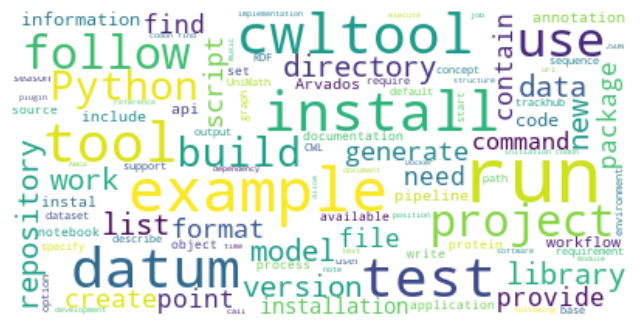

In [7]:
from herc_common.text import plot_word_cloud

complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

## LDA

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

from herc_common.topic_modeling import base_scoring_function, compute_model_results


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = compute_model_results(LatentDirichletAllocation, dtm_tf,
                                    lda_scoring_func, seed=RANDOM_SEED,
                                    min_topics=3, max_topics=10)#, max_iter=100)
lda_results

{LatentDirichletAllocation(n_components=3, random_state=42): -4.719873686287028,
 LatentDirichletAllocation(n_components=4, random_state=42): -3.7748572728572087,
 LatentDirichletAllocation(n_components=5, random_state=42): -5.749680202355594,
 LatentDirichletAllocation(n_components=6, random_state=42): -5.051323122490003,
 LatentDirichletAllocation(n_components=7, random_state=42): -6.017779905916884,
 LatentDirichletAllocation(n_components=8, random_state=42): -5.047292492503436,
 LatentDirichletAllocation(n_components=9, random_state=42): -5.635309802659425}

In [14]:
from herc_common.topic_modeling import get_best_model, print_results_info

print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 4, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -3.7748572728572087


In [15]:
from herc_common.topic_modeling import print_top_words

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: run cwltool test example install package tool version command check
Topic #1: trackhub application model music pipeline create datum generate Arvados run
Topic #2: run install UniMath virtualenv uploader tool Data use code Python
Topic #3: codon position annotation find protein initiation frame transcript reading variation



In [16]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  47.415924
1        1.782994 -295.079681       2        1  22.562714
2      220.811432 -343.832123       3        1  16.619806
3       50.533993  -76.050934       4        1  13.401556, topic_info=            Term       Freq      Total Category  logprob  loglift
1011       codon  21.000000  21.000000  Default  30.0000  30.0000
2427    trackhub  25.000000  25.000000  Default  29.0000  29.0000
1132     cwltool  53.000000  53.000000  Default  28.0000  28.0000
1947    position  16.000000  16.000000  Default  27.0000  27.0000
831   annotation  16.000000  16.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
1995     project   5.456720  34.628559   Topic4  -5.4394   0.1620
2210    sequence   4.795754  19.335136   Topic4  -5.5685   0.6156
1079     contain   4.796364  23.904794   Topic4  -5.5684   0.4036
1428    generate   4.796807  31.307004   Topic4  -5.5683   0.1339
1404      format   4.795680  31.540344   Topic4  -5.5685   0.1262

[262 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.981234      ABox
6         4  0.950626       AUG
12        3  0.696987    Ahrens
38        2  0.936886   Arvados
38        3  0.062459   Arvados
...     ...       ...       ...
2571      3  0.072823      work
2571      4  0.109235      work
2573      1  0.768048  workflow
2573      2  0.153610  workflow
2573      3  0.076805  workflow

[394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])